In [6]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import multiprocessing

import EWOthello.utils.plot_helpers as plt_util
from EWOthello.data.othello import *
from EWOthello.mingpt.dataset import ProbingDataset_noAge, ProbingDataset, CharDataset # AK's mingpt data child 
from EWOthello.mingpt.model import GPT, GPTConfig, GPTforProbing # AKs and KLi GPT models
#from EWOthello.mingpt.trainer import Trainer, TrainerConfig # AKs GPT trainer
from EWOthello.mingpt.probe_trainer import Trainer, TrainerConfig
from EWOthello.mingpt.utils import set_seed, sample # AKs helpers for sampling predictions
from EWOthello.mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer
set_seed(44)

In [7]:
othello = get(ood_num=-1, data_root=None, num_preload=11) # 11 corresponds to over 1 million games
train_dataset = CharDataset(othello) 
print(train_dataset.vocab_size, train_dataset.block_size)

Max num files: 230; Use_num: 11
['gen10e5__20220324_165952.pickle', 'gen10e5__20220324_154919.pickle', 'gen10e5__20220324_164123.pickle', 'gen10e5__20220324_154043.pickle', 'gen10e5__20220324_155251.pickle', 'gen10e5__20220324_160016.pickle', 'gen10e5__20220324_165748.pickle', 'gen10e5__20220324_154002.pickle', 'gen10e5__20220324_155241.pickle', 'gen10e5__20220324_165707.pickle', 'gen10e5__20220324_160046.pickle']


Mem Used: 1.69 GB: 100%|██████████| 11/11 [00:03<00:00,  3.09it/s] 


Deduplicating...
Deduplicating finished with 1099941 games left
Using 20 million for training, 0 for validation
Dataset created has 1099941 sequences, 61 unique words.
61 59


In [3]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model_probe = GPTforProbing(mconf, probe_layer=6)
mode = "synthetic"

if mode=="random":
    model = GPT(mconf)
    model_probe.apply(model._init_weights)
else:
    path = "../EWOthello/ckpts/gpt_championship.ckpt" if mode=="championship" else "../EWOthello/ckpts/gpt_synthetic.ckpt"
    model_probe.load_state_dict(torch.load(path))

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model_probe = model_probe.to(device)
    model = model.to(device)


torch.Size([1, 59, 61])
torch.Size([1, 59, 512])
[19, 18, 17, 9, 1, 0]
['c4', 'c3', 'c2', 'b2', 'a2', 'a1']


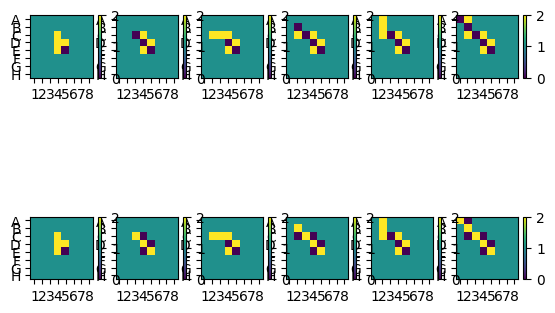

In [5]:
### BASIC TEST CODE SCRIPTING

#######
### Simple dimensionality check
x, y = train_dataset[0]
x = torch.unsqueeze(x, 0)

model_out_logits = model(x.to(device))[0]
print(model_out_logits.shape)

probe_activation = model_probe(x.to(device))
print(probe_activation.shape)

######
#### mini-example before getting to the main part
properties_modifier_matrix = np.ones((59, 64))
for i in range(59):
    if i % 2 == 1:
        properties_modifier_matrix[i,:] *= -1.


# Grab a single game sequence index vector x
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
it = iter(loader)
x,_ = next(it)

act_container = []
property_container = []

# Note the sequence length and get tbf = index to tokens
tbf = [train_dataset.itos[_] for _ in x.tolist()[0]] # Index to string (converts the sequence to board state)
valid_until = tbf.index(-100) if -100 in tbf else 999 # Get true length of game sequence (excluding filler token -100) 

# Get the activation output features
act = model_probe(x.to(device))[0].detach().cpu()  # [block_size, f]
act = [_[0] for _ in act.split(1, dim=0)[:valid_until]]  # list of activations after the n-th layer block
act_container.extend(act)

# Get the board state
a = OthelloBoardState()
properties = a.get_gt(tbf[:valid_until], "get_state")
properties_v2 = (np.array(properties) - 1.0) * properties_modifier_matrix[:valid_until, :] + 1.0

# Visualize the corresponding board states
num = 6
fig = plt.figure()
ax = plt_util.addAxis(fig, 2, num)
print(tbf[:num])
print([permit_reverse(move) for move in tbf[:num]])

for i in range(num):
    board = np.reshape(np.array(properties[i]), [8,8])
    board_v2 = np.reshape(np.array(properties_v2[i]), [8,8])

    im = ax[i].imshow(board)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[i+num].imshow(board_v2)
    divider = make_axes_locatable(ax[i+num])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt_util.format_ax_boardImage(ax)


# # Get the "age"
# a = OthelloBoardState()
# ages = a.get_gt(tbf[:valid_until], "get_age")  # [block_size, ]
# fig = plt.figure()
# ax = plt_util.addAxis(fig, 1,num)
# for i in range(num):
#     out = np.reshape(np.array(ages[i]), [8,8])
#     ax[i].imshow(out)
# plt.show()

In [7]:
## mini-example before getting to the main part
properties_modifier_matrix = np.ones((59, 64))
for i in range(59):
    if i % 2 == 1:
        properties_modifier_matrix[i,:] *= -1.

loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)

# Loop and get the board state vectors
property_container_v2 = []
for x, _ in tqdm(loader, total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]] # Index to string (converts the sequence to board state)
    valid_until = tbf.index(-100) if -100 in tbf else 999
    
    a = OthelloBoardState()
    properties = a.get_gt(tbf[:valid_until], "get_state")  # [block_size, ]
    properties_v2 = (np.array(properties) - 1.0) * properties_modifier_matrix[:valid_until, :] + 1.0
    property_container_v2.extend(properties_v2.tolist())

    #act = model_probe(x.to(device))[0].detach().cpu()  # [block_size, f]
    #act_container.extend([_[0] for _ in act.split(1, dim=0)[:valid_until]])


# act_container = []
# #property_container = []
# property_container_v2 = []
# for x, y in tqdm(loader, total=len(loader)):
#     tbf = [train_dataset.itos[_] for _ in x.tolist()[0]] # Index to string (converts the sequence to board state)
#     valid_until = tbf.index(-100) if -100 in tbf else 999
    
#     a = OthelloBoardState()
#     properties = a.get_gt(tbf[:valid_until], "get_state")  # [block_size, ]
#     #property_container.extend(properties)

#     properties_v2 = (np.array(properties) - 1.0) * properties_modifier_matrix[:valid_until, :] + 1.0
#     property_container_v2.extend(properties_v2.tolist())
        
#     act = model_probe(x.to(device))[0].detach().cpu()  # [block_size, f]
#     act_container.extend([_[0] for _ in act.split(1, dim=0)[:valid_until]])

# # age_container = []
# # for x, y in tqdm(loader, total=len(loader)):
# #     tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
# #     valid_until = tbf.index(-100) if -100 in tbf else 999
# #     a = OthelloBoardState()
# #     ages = a.get_gt(tbf[:valid_until], "get_age")  # [block_size, ]
# #     age_container.extend(ages)


 21%|██▏       | 235638/1099941 [07:44<28:23, 507.28it/s]  


KeyboardInterrupt: 

In [50]:
# #
# loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
# properties_modifier_matrix = np.ones((59, 64))
# for i in range(59):
#     if i % 2 == 1:
#         properties_modifier_matrix[i,:] *= -1.

# def gen_probe_dataset(iterable):
#     x = iterable[0] # get the sequence and drop the next y second term
#     tbf = [train_dataset.itos[_] for _ in x.tolist()[0]] # Index to string (converts the sequence to board state)
#     valid_until = tbf.index(-100) if -100 in tbf else 999
    
#     a = OthelloBoardState()
#     properties = a.get_gt(tbf[:valid_until], "get_state")  # [block_size, ]
#     properties_v2 = (np.array(properties) - 1.0) * properties_modifier_matrix[:valid_until, :] + 1.0        
#     act = model_probe(x)[0].detach()  # [block_size, f]

#     return properties, properties_v2, act
    
# p = multiprocessing.Pool(multiprocessing.cpu_count())
# for can in tqdm(p.imap(gen_probe_dataset, loader, chunksize=1)):
#     print(can)    
    
# p.close()

# # def parallel_process(iterable, function, num_processes=None):
# #     with multiprocessing.Pool(num_processes) as pool:
# #         results = pool.imap(function, iterable)

# #     return list(results)

# # #
# # results = parallel_process(loader, gen_probe_dataset, multiprocessing.cpu_count())
# # #print(list(results))



0it [00:00, ?it/s]

In [27]:
#probing_dataset = ProbingDataset(act_container, property_container_v2, age_container)


probing_dataset  = ProbingDataset_noAge(act_container, property_container_v2)
probe = BatteryProbeClassification(device, probe_class=3, num_task=64)

# probing dataset returns activation, y, and age
# Porbe at the dataloader
it = iter(probing_dataset)
act, y, age = next(it)

print(act.shape)
print(len(act), len(y), len(age))

589904 pairs loaded...
9237424 17697741 10818691
[1895944, 2229884, 2170580, 1912762, 1863669, 1657755, 1614941, 1447185, 1409081, 1271293, 1237100, 1122944, 1091850, 996063, 967937, 887162, 860984, 792900, 768992, 710404, 688316, 638187, 617785, 574105, 554796, 516984, 498823, 465772, 448655, 419754, 403412, 377770, 362363, 339516, 324728, 304349, 290282, 271749, 258255, 241462, 228429, 212943, 200484, 186328, 174291, 161075, 149388, 136975, 125624, 113945, 102974, 91947, 81345, 70729, 60423, 50202, 40139, 30064, 20041, 10017]
torch.Size([512])
512 64 64


In [28]:
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])

sampler = None
train_loader = DataLoader(train_dataset, shuffle=False, sampler=sampler, pin_memory=True, batch_size=128, num_workers=1)
test_loader = DataLoader(test_dataset, shuffle=True, pin_memory=True, batch_size=128, num_workers=1)

savepath = "../EWOthello/ckpts/"
max_epochs = 50
t_start = time.strftime("_%Y%m%d_%H%M%S")
tconf = TrainerConfig(
    max_epochs=max_epochs,
    batch_size=1024,
    learning_rate=1e-3,
    betas=(0.9, 0.999),
    lr_decay=True,
    warmup_tokens=len(train_dataset) * 5,
    final_tokens=len(train_dataset) * max_epochs,
    num_workers=4,
    weight_decay=0.0,
    ckpt_path=savepath + f"probe_test_at{t_start}.ckpt", 
)

trainer = Trainer(probe, train_dataset, test_dataset, tconf)
trainer.train(prt=True)
trainer.save_traces()
trainer.save_checkpoint()


Decayed: {'proj.weight', 'proj.bias'}


epoch 1: train loss 0.14594; lr 1.00e-03; train acc 96.51%: 100%|██████████| 461/461 [00:05<00:00, 82.22it/s]
epoch 2: train loss 0.04649; lr 1.00e-03; train acc 98.93%: 100%|██████████| 461/461 [00:05<00:00, 84.75it/s]
epoch 3: train loss 0.03987; lr 1.00e-03; train acc 98.99%: 100%|██████████| 461/461 [00:05<00:00, 84.01it/s]
epoch 4: train loss 0.03742; lr 1.00e-03; train acc 99.01%: 100%|██████████| 461/461 [00:05<00:00, 82.16it/s]
epoch 5: train loss 0.03670; lr 1.00e-03; train acc 99.02%:  52%|█████▏    | 238/461 [00:02<00:02, 85.04it/s]


KeyboardInterrupt: 